In [2]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")

In [3]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_openai import ChatOpenAI
from typing import Annotated

In [4]:
from templates import *
from langchain_experimental.tools import PythonREPLTool

In [5]:
python_repl_tool = PythonREPLTool()

In [6]:
def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    """Creating an Agent"""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name='messages'),
            MessagesPlaceholder(variable_name='agent_scratchpad')
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [7]:
def agent_node(state, agent, name, log):
    result = agent.invoke(state)
    log[name] = result["output"]
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

### Create Agent Supervisor

It will use function calling to choose the next worker node OR finish processing.

In [8]:
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser

members = ["Noter", "Explainer", "Validator"]
system_prompt = (
    "你是一名监督员，负责管理以下成员之间的对话：{members}。"
    "根据以下用户请求，指定下一个需要行动的成员。每个成员将执行一个任务,"
    "你的任务是检查Noter的解题板书中用到的知识点对于一个一年级学生来说是否超纲"
    "如果超纲应该将修改建议返回给Noter让其根据修改建议重新生成不包含超纲内容的解题板书"
    "当Noter返回的内容符合标准时，请将Noter的板书传递给Explainer，并让其学习相似题目中"
    "老师的讲解风格以及讲题思路，生成题目解析"
    "每一步反馈他们的结果和状态。任务完成后，请回复“FINISH”。"
)

options = ["FINISH"] + members

function_def = {
    "name" : "route",
    "description": "选择下一步应该由谁来执行",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    }
}

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "根据以上内容，下一步应该轮到谁了？"
            "或者我们是否已经得到不错的讲解，可以“完成”了呢？"
            "请从以下选项中选一个：{options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI(model="gpt-4o", max_tokens=1000)

supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

In [13]:
validate_prompt = "你的任务是检查Noter的解题板书中用到的知识点对于一个小学一年级学生来说是否超纲,如果超纲应该将修改建议返回给Noter让其根据修改建议重新生成不包含超纲内容的解题板书"

In [14]:
import functools
import operator
from typing import Sequence, TypedDict

from langgraph.graph import END, StateGraph, START

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str
log = {}

noter_agent = create_agent(llm, [python_repl_tool], template_note)
noter_node = functools.partial(agent_node, agent=noter_agent, name="Noter", log=log)

explainer_agent = create_agent(llm, [python_repl_tool], template_expl)
explainer_node = functools.partial(agent_node, agent=explainer_agent, name="Explainer", log=log)

validator_agent = create_agent(llm, [python_repl_tool], validate_prompt)
validator_node = functools.partial(agent_node, agent=validator_agent, name="Validator", log=log)


def supervisor_node(state, log):
    result = supervisor_chain.invoke(state)
    log["Supervisor"] = result
    return result

workflow = StateGraph(AgentState)
workflow.add_node("Noter", noter_node)
workflow.add_node("Explainer", explainer_node)
workflow.add_node("Validator", validator_node)
workflow.add_node("Supervisor", functools.partial(supervisor_node, log=log))

In [15]:
for member in members:
    workflow.add_edge(member, "Supervisor")

conditional_map = {k:k for k in members}
conditional_map['FINISH'] = END
workflow.add_conditional_edges("Supervisor", lambda x: x["next"], conditional_map)
workflow.add_edge(START, "Supervisor")

graph = workflow.compile()

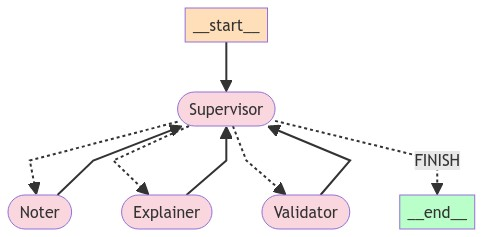

In [33]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="2022年参加北京冬奥会的总人数为2892人，比第一届夏蒙尼冬奥会的12倍少204人，参加第一届冬奥会人数是多少人？")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'Supervisor': {'next': 'Noter'}}
----
{'Noter': {'messages': [HumanMessage(content='知识点讲解:本题考查的知识点是方程的应用，解题关键点是设未知数并根据题意列出方程进行求解。\n\n###板书一:\n设第一届冬奥会参加人数为$x$人\n\n依题意得：\n$2892 = 12x - 204$\n\n###板书二:\n解方程：\n$12x - 204 = 2892$\n$12x = 2892 + 204$\n$12x = 3096$\n$x = \\frac{3096}{12}$\n$x = 258$\n\n故答案是258人。', name='Noter')]}}
----
{'Supervisor': {'next': 'Validator'}}
----
{'Validator': {'messages': [HumanMessage(content='这个解题过程涉及到设未知数和解方程的知识点，这对于小学一年级的学生来说是超纲的。小学一年级的学生通常还没有学习方程的概念。我们可以使用更简单的加减法和乘除法来解决这个问题。\n\n### 修改建议:\n用更简单的加减法和乘除法来解决问题，避免使用方程。\n\n### 修改后的板书:\n1. 先算出2892人比第一届冬奥会的12倍少了多少人。\n   \\[\n   2892 + 204 = 3096\n   \\]\n\n2. 然后求第一届冬奥会的参加人数。\n   \\[\n   \\frac{3096}{12} = 258\n   \\]\n\n所以，第一届冬奥会参加的人数是258人。', name='Validator')]}}
----
{'Supervisor': {'next': 'Noter'}}
----
{'Noter': {'messages': [HumanMessage(content='知识点讲解:本题考查的知识点是加减法和乘除法的应用，解题关键点是根据题意进行加法与除法运算来求解。\n\n###板书一:\n先算出2892人比第一届冬奥会的12倍少了多少人：\n$2892 + 204 = 3096$\n\n###板书二:\n然后求第一届冬奥会的参加人数：\n$\\frac{3096}{12} = 258$\

In [34]:
print(graph.astream_log)

<bound method Runnable.astream_log of CompiledStateGraph(nodes={'__start__': PregelNode(config={'tags': ['langsmith:hidden']}, channels=['__start__'], triggers=['__start__'], writers=[ChannelWrite<messages,next>(recurse=True, writes=[ChannelWriteEntry(channel='messages', value=<object object at 0x103e2e080>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='next', value=<object object at 0x103e2e080>, skip_none=False, mapper=_get_state_key(recurse=False))], require_at_least_one_of=['messages', 'next']), ChannelWrite<start:Supervisor>(recurse=True, writes=[ChannelWriteEntry(channel='start:Supervisor', value='__start__', skip_none=False, mapper=None)], require_at_least_one_of=None)]), 'Noter': PregelNode(config={'tags': []}, channels={'messages': 'messages', 'next': 'next'}, triggers=['branch:Supervisor:condition:Noter'], mapper=functools.partial(<function _coerce_state at 0x10bee2e60>, <class '__main__.AgentState'>), writers=[ChannelWrite<Noter,messages,

In [19]:
print("记录日志:")
for agent, output in log.items():
    print(f"{agent}: {output}")

记录日志:
Supervisor: {'next': 'FINISH'}
Noter: 知识点讲解:本题考查的知识点是方程的解法，解题关键点是设未知数并列方程求解。

###板书一:
设第一届冬奥会的人数为$x$人

依题意得:
2892 = 12x - 204

###板书二:
12x = 2892 + 204
12x = 3096
x = 3096 ÷ 12
x = 258

故答案是258人。
Explainer: ###讲解一:
首先，我们需要设第一届冬奥会的人数为 $x$ 人。根据题意，2022年参加北京冬奥会的总人数是2892人，这个数字比第一届冬奥会的人数的12倍少204人。我们可以将这个关系用一个方程表示出来：

\[ 2892 = 12x - 204 \]

这是我们需要解的方程。

###讲解二:
接下来我们要解这个方程。首先我们将方程的右边增加204，以消去常数项，得到：

\[ 12x = 2892 + 204 \]
\[ 12x = 3096 \]

然后，我们将方程的两边同时除以12，以解出 $x$：

\[ x = \frac{3096}{12} \]
\[ x = 258 \]

所以，参加第一届冬奥会的人数是258人。
